#### Predicting with Regressor Algorithms

Refering to [choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
I now suspect labeling into three classes, low performer (below 100K), normal, viral(>5m, in 3-5 day) is the best route for this use case...

Accuracy is not a good measure for regressor

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

Loading in Data

In [2]:
data_csv_fname = "../../data/finalized_bzfd_data.csv"
bzfd_df = pd.read_csv(data_csv_fname, sep=',', index_col=0).dropna()

Y = bzfd_df['logViewCount']
X = bzfd_df.iloc[:,20:-1]

Splitting into Training/Test Data

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=519)

In [4]:
def RegressorMetrics (X_train, Y_train, X_test, Y_test, fitted_model):
    Y_pred = fitted_model.predict(X_test)
    train_accuracy = fitted_model.score(X_train, Y_train)
    test_accuracy = fitted_model.score(X_test, Y_test)
    test_mse = mean_squared_error(Y_test, Y_pred)
    test_r2 = r2_score(Y_test, Y_pred)
    return train_accuracy, test_accuracy, test_mse, test_r2

Baseline Model: **Linear Regression**

In [5]:
baseline_model = LinearRegression()
fitted_baseline = baseline_model.fit(X_train, Y_train)

/Users/chuamelia/anaconda/envs/py35/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
print(RegressorMetrics(X_train, Y_train, X_test, Y_test, fitted_baseline))

(0.2285781482683532, 0.1837080687485243, 1.3132794915567256, 0.1837080687485243)


#### Lasso

In [7]:
lasso_results = []
alphas = list(set([10**i for i in range(-8,-1)] + [0.01 * i for i in range(11)]))
for a in alphas:
    if a != 0:
        params = {'alpha': a, 'random_state':519}
        model = Lasso(**params)
        fitted_model = model.fit(X_train, Y_train)
        train_accuracy, test_accuracy, test_mse, test_r2 = RegressorMetrics(X_train, Y_train, X_test, Y_test,  fitted_model)
        results = ('Lasso',a,train_accuracy, test_accuracy, test_mse, test_r2)
        lasso_results.append(results)

In [8]:
lasso_pd = pd.DataFrame(lasso_results, columns = ['model','alpha','train_accuracy', 'test_accuracy','mse','r2'])
lasso_pd.sort_values(by='r2',ascending=False).head(5)

,model,alpha,train_accuracy,test_accuracy,mse,r2
15,Lasso,1.000000e-03,0.224764,0.188670,1.305296,0.188670
10,Lasso,1.000000e-04,0.228530,0.184616,1.311819,0.184616
7,Lasso,1.000000e-05,0.228578,0.183806,1.313122,0.183806
14,Lasso,1.000000e-06,0.228578,0.183718,1.313264,0.183718
13,Lasso,1.000000e-07,0.228578,0.183709,1.313278,0.183709


Text(0.5, 1.0, 'Model r2 by \nC & kernel')

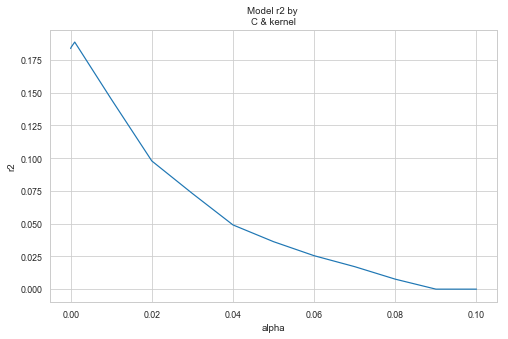

In [9]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 5))

sns.lineplot(x='alpha', y='r2', data = lasso_pd   )\
.set_title('Model r2 by \nC & kernel')

#### ElasticNet

In [10]:
en_results = []
alphas = [round(0.001*i, 3 ) for i in range(1,50)]
loss = [round(0.1 * i,2) for i in range(1,11)]
for a in alphas:
    for l in loss:
        params = {'alpha': a, 'l1_ratio':l, 'random_state':519}
        model = ElasticNet(**params)
        fitted_model = model.fit(X_train, Y_train)
        train_accuracy, test_accuracy, test_mse, test_r2 = RegressorMetrics(X_train, Y_train, X_test, Y_test,  fitted_model)
        results = ('ElasticNet',a, l, train_accuracy, test_accuracy, test_mse, test_r2)
        en_results.append(results)

In [11]:
cols = ['model','alpha','l1_ratio','train_accuracy', 'test_accuracy','mse','r2']
en_pd = pd.DataFrame(en_results, columns = cols )
en_pd.sort_values(by='r2',ascending=False).head(5)

,model,alpha,l1_ratio,train_accuracy,test_accuracy,mse,r2
12,ElasticNet,0.002,0.3,0.224588,0.189208,1.304431,0.189208
13,ElasticNet,0.002,0.4,0.223766,0.189177,1.304480,0.189177
14,ElasticNet,0.002,0.5,0.222807,0.189175,1.304484,0.189175
20,ElasticNet,0.003,0.1,0.223734,0.189156,1.304515,0.189156
21,ElasticNet,0.003,0.2,0.222571,0.189141,1.304539,0.189141


Text(0.5, 1.0, 'Model r2 by \nC & kernel')

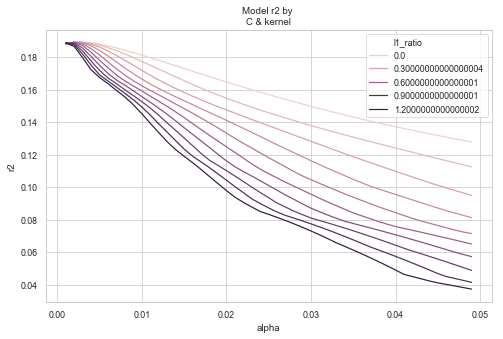

In [12]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 5))

sns.lineplot(x='alpha', y='r2', hue='l1_ratio', data = en_pd   )\
.set_title('Model r2 by \nC & kernel')

#### Ridge

In [13]:
ridge_results = []
alphas = [round(0.1 * i, 2) for i in range(200)]
for a in alphas:
    if a != 0:
        params = {'alpha': a, 'random_state':519}
        model = Ridge(**params)
        fitted_model = model.fit(X_train, Y_train)
        train_accuracy, test_accuracy, test_mse, test_r2 = RegressorMetrics(X_train, Y_train, X_test, Y_test,  fitted_model)
        results = ('Ridge',a,train_accuracy, test_accuracy, test_mse, test_r2)
        ridge_results.append(results)

In [14]:
cols = ['model','alpha','train_accuracy', 'test_accuracy','mse','r2']
ridge_pd = pd.DataFrame(ridge_results, columns = cols )
ridge_pd.sort_values(by='r2',ascending=False).head(5)

,model,alpha,train_accuracy,test_accuracy,mse,r2
161,Ridge,16.2,0.224311,0.189137,1.304545,0.189137
162,Ridge,16.3,0.224274,0.189137,1.304545,0.189137
160,Ridge,16.1,0.224348,0.189137,1.304546,0.189137
163,Ridge,16.4,0.224237,0.189137,1.304546,0.189137
159,Ridge,16.0,0.224384,0.189136,1.304546,0.189136


Text(0.5, 1.0, 'Model r2 by \nC & kernel')

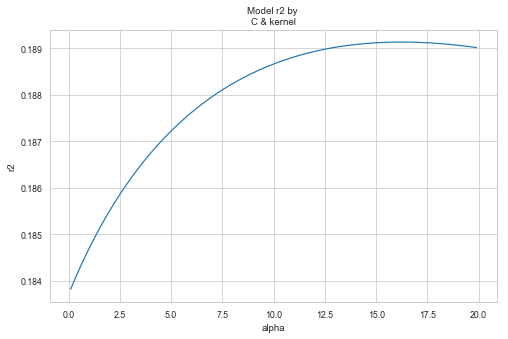

In [15]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 5))

sns.lineplot(x='alpha', y='r2', data = ridge_pd   )\
.set_title('Model r2 by \nC & kernel')

#### Linear SVC

Should try adjusting epsilon...


In [17]:
degrees = [i for i in range(2,9)]
cs = [round(0.1*i,2) for i in range(1,21)]
lsvc_results = []
for c in cs:
    print("I'm making progress: " + str(c))
    if c != 0:
        for d in degrees:
            params = {'C':c, 'kernel':'linear', 'degree':d}
            model = SVR(**params)
            fitted_model = model.fit(X_train, Y_train)
            train_accuracy, test_accuracy, test_mse, test_r2 = RegressorMetrics(X_train, Y_train, X_test, Y_test,  fitted_model)
            results = ('LinearSVR', c, d, train_accuracy, test_accuracy, test_mse, test_r2)
            lsvc_results.append(results)

I'm making progress: 0.1
I'm making progress: 0.2
I'm making progress: 0.3
I'm making progress: 0.4
I'm making progress: 0.5
I'm making progress: 0.6
I'm making progress: 0.7
I'm making progress: 0.8
I'm making progress: 0.9
I'm making progress: 1.0
I'm making progress: 1.1
I'm making progress: 1.2
I'm making progress: 1.3
I'm making progress: 1.4
I'm making progress: 1.5
I'm making progress: 1.6
I'm making progress: 1.7
I'm making progress: 1.8
I'm making progress: 1.9
I'm making progress: 2.0


In [18]:
cols = ['model','C','degree','train_accuracy', 'test_accuracy','mse','r2']
lsvc_pd = pd.DataFrame(lsvc_results, columns = cols )
lsvc_pd.sort_values(by='r2',ascending=False).head(5)

,model,C,degree,train_accuracy,test_accuracy,mse,r2
0,LinearSVR,0.1,2,0.218719,0.190783,1.301898,0.190783
2,LinearSVR,0.1,4,0.218719,0.190783,1.301898,0.190783
3,LinearSVR,0.1,5,0.218719,0.190783,1.301898,0.190783
4,LinearSVR,0.1,6,0.218719,0.190783,1.301898,0.190783
5,LinearSVR,0.1,7,0.218719,0.190783,1.301898,0.190783


Text(0.5, 1.0, 'Model r2 by \nC & kernel')

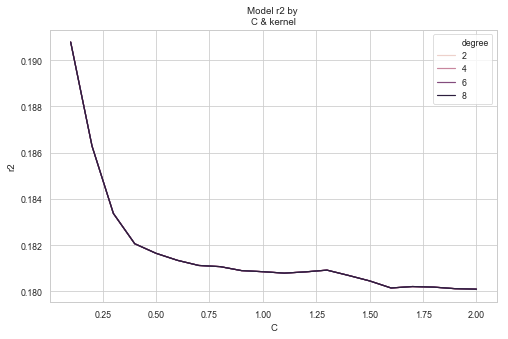

In [19]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 5))

sns.lineplot(x='C', y='r2', hue='degree',data = lsvc_pd   )\
.set_title('Model r2 by \nC & kernel')

#### Radial Basis Function SVR

In [20]:
degrees = [i for i in range(2,9)]
cs = [10**exp for exp in range(-8, 2)]
rsvc_results = []
for c in cs:
    if c != 0:
        for d in degrees:
            params = {'C':c, 'kernel':'rbf','gamma':'auto', 'degree':d}
            model = SVR(**params)
            fitted_model = model.fit(X_train, Y_train)
            train_accuracy, test_accuracy, test_mse, test_r2 = RegressorMetrics(X_train, Y_train, X_test, Y_test,  fitted_model)
            results = ('rbfSVR', c, d, train_accuracy, test_accuracy, test_mse, test_r2)
            rsvc_results.append(results)

In [21]:
cols = ['model','C','degree','train_accuracy', 'test_accuracy','mse','r2']
rsvc_pd = pd.DataFrame(rsvc_results, columns = cols )
rsvc_pd.sort_values(by='r2',ascending=False).head(5)

,model,C,degree,train_accuracy,test_accuracy,mse,r2
69,rbfSVR,10.0,8,0.252793,0.199106,1.288507,0.199106
68,rbfSVR,10.0,7,0.252793,0.199106,1.288507,0.199106
67,rbfSVR,10.0,6,0.252793,0.199106,1.288507,0.199106
66,rbfSVR,10.0,5,0.252793,0.199106,1.288507,0.199106
65,rbfSVR,10.0,4,0.252793,0.199106,1.288507,0.199106


Text(0.5, 1.0, 'Model r2 by \nC & kernel')

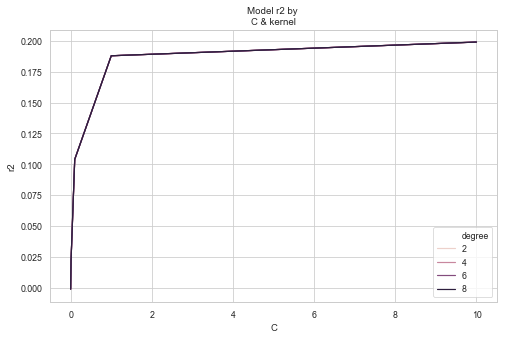

In [22]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 5))

sns.lineplot(x='C', y='r2', hue='degree',data = rsvc_pd)\
.set_title('Model r2 by \nC & kernel')

#### Random Forest Regressor

In [ ]:
params = {'n_estimators': n, 'criterion':'mse', 
          'max_depth': d, 'min_samples_split': s, 
          'min_samples_leaf':l, 'random_state': 519}

### Comparing the Best Models 

In [30]:
lasso_pd[lasso_pd['mse'] == lasso_pd['mse'].min()][['model','mse','r2']]

,model,mse,r2
15,Lasso,1.305296,0.18867


In [31]:
en_pd[en_pd['mse'] == en_pd['mse'].min()][['model','mse','r2']]

,model,mse,r2
12,ElasticNet,1.304431,0.189208


In [32]:
rsvc_pd[rsvc_pd['mse'] == rsvc_pd['mse'].min()][['model','mse','r2']]

,model,mse,r2
63,rbfSVR,1.288507,0.199106
64,rbfSVR,1.288507,0.199106
65,rbfSVR,1.288507,0.199106
66,rbfSVR,1.288507,0.199106
67,rbfSVR,1.288507,0.199106
68,rbfSVR,1.288507,0.199106
69,rbfSVR,1.288507,0.199106


In [33]:
lsvc_pd[lsvc_pd['mse'] == lsvc_pd['mse'].min()][['model','mse','r2']]

,model,mse,r2
0,LinearSVR,1.301898,0.190783
1,LinearSVR,1.301898,0.190783
2,LinearSVR,1.301898,0.190783
3,LinearSVR,1.301898,0.190783
4,LinearSVR,1.301898,0.190783
5,LinearSVR,1.301898,0.190783
6,LinearSVR,1.301898,0.190783
